# DCGAN on CIFAR-10 dataset

Here we will implement a DCGAN on the CIFAR-10 dataset.

DCGANs were first introduced in https://arxiv.org/abs/1511.06434 

This implementation requires **Tensorflow 2.0**. The first few cells are only related to Google Colab and Google Drive, you can ignore them.

In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

If executing on Google Colab, mount your Google Drive (click the link, connect and enter the password)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("drive/My Drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports, helper functions and preliminaries

Importing the libraries

In [0]:
# Coding
import tensorflow as tf 
from tensorflow.keras import layers
import numpy as np

# Plotting and manipulating images
import matplotlib.pyplot as plt
import imageio
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Managing the folders 
import os
import shutil

Creating the folders

In [0]:
# Removing the old images generated during training

NAME_FILE = "Kernel size" + os.sep + "4x4"

rm_path = "." + os.sep + NAME_FILE + os.sep + "imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Creating folders to save images, models and checkpoints
newpaths = ["." + os.sep + NAME_FILE + os.sep + "imgs", 
            "." + os.sep + NAME_FILE + os.sep + "models",
            "." + os.sep + NAME_FILE + os.sep + "losses"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Helper functions

In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASSES)

def generate_and_save_images(model,
                             epoch,
                             test_input,
                             g_loss,
                             d_loss,
                             conditions=None,
                             x_axis="scale",
                             y_max=5,
                             save=True):

  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    if conditions is not None:
        predictions = model([test_input, conditions], training=False)
    else:
        predictions = model([test_input], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5,
                  subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i]+1) / 2 )
        if conditions is not None:
            ax.title.set_text(CLASSES[np.argmax(conditions[i])])
        ax.axis('off')
        fig.add_subplot(ax)
    
    if save:
        fig.savefig("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
    
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1,
                  subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 1000
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)

    ax1.plot(xs, g_losses_sampled, "r-")
    ax1.plot(xs, d_losses_sampled, "b-")

    red_patch = mpatches.Patch(color='red', label='Generator loss')
    blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
    ax1.legend(handles=[red_patch,blue_patch])
    
    if x_axis == "total":
        ax1.set_xlim([0, train_images.shape[0]//BATCH_SIZE * EPOCHS])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    ax1.set_ylim([0, y_max])
    
    
    
    fig.add_subplot(ax1)
    
    plt.show()


# Hyperparameters

In [0]:
# Training parameters
EPOCHS =         200
BATCH_SIZE =     128       # Amount of images processed before backpropagating

# Models parameters
NOISE_DIM =      100      # Amount of features for the generator
KERNEL_SIZE =    (4, 4)   # Medium kernel size for the convolutional layers
MOMENTUM =       0.9      # Momentum for the batch normalization layers
DROPOUT =        0.4      # Dropout rate
ALPHA =          0.2      # Alpha for the leaky ReLU slope

# Optimizer parameters
LEARNING_RATE =  2e-4     # Learning rate for the Adam Optimizer
BETA_1 =         0.5      # Beta_1 for the Adam Optimizer
BETA_2 =         0.9      # Beta_2 for the Adam Optimizer

# Display parameters
NUM_EXAMPLES =   20       # Amount of examples to generate

# Data loading and preprocessing

Loading and preprocessing the dataset. We will use CIFAR-10.

In [7]:
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Shape of the training dataset
IMAGE_SIZE =     train_images.shape[-2] # Size of the images of the training dataset (width and height)
IMAGE_CHANNELS = train_images.shape[-1] # Amount of channels of the training dataset (depth)

# Preprocessing the dataset
train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS).astype('float32')
train_images = (train_images - 127.5) / 127.5

170500096/170498071 [==============================] - 3s 0us/step


# Network Architecture

In this section, we will detail what architectures are used for training the DCGAN.

**For our generator, we will use the following architecture :**

In [0]:
def generator_model(input_layer, verbose=False):
    
    hid = layers.Dense(256 * 4 * 4)(input_layer)
    hid = layers.Reshape((4, 4, 256))(hid)
    hid = layers.ReLU()(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 4 ==> 8
    hid = layers.Conv2DTranspose(   256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 8 ==> 16
    hid = layers.Conv2DTranspose(   128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 16 ==> 32    
    hid = layers.Conv2DTranspose(   64, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    hid = layers.Conv2D(IMAGE_CHANNELS, kernel_size=KERNEL_SIZE, strides=(1, 1), padding="same")(hid)
    out = layers.Activation("tanh")(hid)

    model = tf.keras.Model(inputs=[input_layer], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

**For our discriminator, we will use the following architecture :**

In [0]:
def discriminator_model(input_layer, verbose=False):

    # 32 ==> 16
    hid = layers.Conv2D(64,  kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(input_layer) 
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 16 ==> 8
    hid = layers.Conv2D(128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 8 ==> 4
    hid = layers.Conv2D(256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 4 ==> 1
    out = layers.Conv2D(1,   kernel_size=(4, 4))(hid)
    
    model = tf.keras.Model(inputs=[input_layer], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

Loading the generator

In [10]:
noise_input = layers.Input(shape=(NOISE_DIM,)) # Noise input
generator = generator_model(noise_input, verbose=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1048576   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 256)         0     

Loading the discriminator

In [11]:
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)) # Image input
discriminator = discriminator_model(img_input, verbose=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512 

# Optimizers and losses

In [0]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The discriminator will try to recognize ground truth data by predicting 1, and to recognize the generated images by predicting 0. Thus, we will use the binary crossentropy of the difference between the values predicted and the expected values as a measure of the loss. 

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

The generator will try to fool the discriminator by making the generated images’ predictions be the closest to 1. We will then use the binary crossentropy of the difference between the discriminator’s predictions over generated data and 1 as a measure of the loss.

In [0]:
def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

For both the generator and the discriminator, we will use the Adam optimizer.

In [0]:
generator_optimizer =     tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

# Training

We code the train steps manually to have complete control over the process.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be converted 
# from Eager mode of Tensorflow (easier to code but slower to execute) 
# to Graph mode (harder to code but faster to execute)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To make sure we know what is done, we will use a gradient tape instead of compiling
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Training the generator
        generated_images = generator([noise] , training=True) 

        # Training the discriminator
        real_output = discriminator([images], training=True)           # Training the discriminator on real images
        fake_output = discriminator([generated_images], training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss =  generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Building the gradients
        gradients_of_generator =     gen_tape.gradient( gen_loss,  generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Applying the gradients (backpropagation)
        generator_optimizer.apply_gradients(    zip(gradients_of_generator,     generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss


In [0]:
g_losses = []
d_losses = []
def train(train_images, epochs, seed):

    num_batches = int(train_images.shape[0]/BATCH_SIZE) # Amount of batches
    for epoch in range(epochs):
        start = time.time() # Timing the epoch

        for batch_idx in range(num_batches): # For each batch
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            gen_loss, disc_loss = train_step(images)
            
            # Saving the losses
            g_losses.append(np.array(gen_loss))  
            d_losses.append(np.array(disc_loss))

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 g_losses,
                                 d_losses,
                                 x_axis='total')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               g_losses,
                               d_losses,
                               x_axis='total')

We will reuse this seed overtime, so it's easier to visualize progress in the animated GIF.

In [0]:
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

This following cell launches the training.

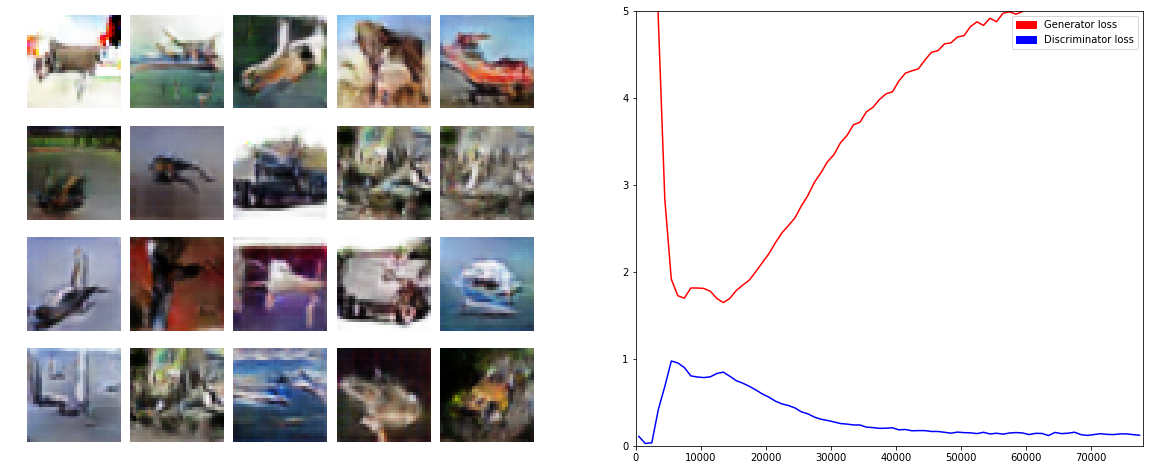

CPU times: user 45min 59s, sys: 25min 31s, total: 1h 11min 31s
Wall time: 1h 14min 22s


In [19]:
%%time
# Training
train(train_images, EPOCHS, seed)

# Immedialty save the models
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'discriminator.h5')

# Saving and loading the models

Saving the models and the losses

In [0]:
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'discriminator.h5')

np.save("." + os.sep + NAME_FILE + os.sep + 'losses' + os.sep + 'g_losses_cond.npy',g_losses)
np.save("." + os.sep + NAME_FILE + os.sep + 'losses' + os.sep + 'd_losses_cond.npy',d_losses)

Loading the models

In [21]:
generator_l =     tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "generator.h5")
discriminator_l = tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "discriminator.h5")

W0621 13:01:52.840308 140666121582464 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0621 13:01:53.041271 140666121582464 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


# Visualizing the losses

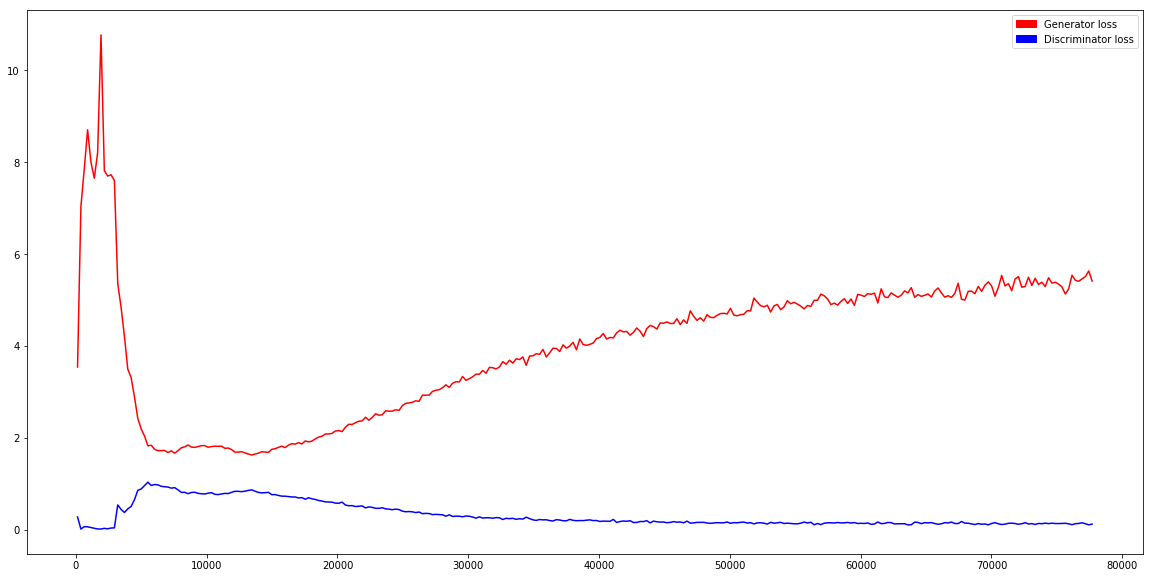

In [22]:
samples = 256
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.figure(figsize=(20,10))
  
plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

red_patch =  mpatches.Patch(color='red',  label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


# Generating a GIF of the training process

In [0]:
anim_file = "." + os.sep + NAME_FILE + os.sep + 'CIFAR-10.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Generating samples from a specific class

Generating images...


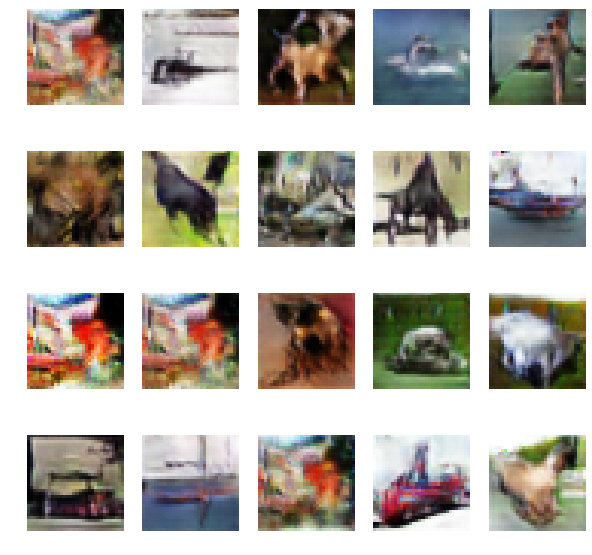

In [24]:
def show_class(model, k=None, classes=None):
    if classes:
        print("Generating {} images...".format(classes[k]))
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels = tf.one_hot([k]*NUM_EXAMPLES,10)
        predictions = model([input, labels], training=False)
    else:
        print("Generating images...")
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels=None
        predictions = model([input], training=False)
        

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        if classes:
            plt.title(classes[k])
        plt.imshow((predictions[i]+1) / 2)
        plt.axis('off')
    plt.show()
    
show_class(generator_l)